In [16]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageUtil as util
import json
from IPython import embed
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.svm import SVC



In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython import embed

def findInterestPoints(img, detector, stride = 10):
    keypoints = []

    if detector == "Dense":
        for i in np.arange(0, img.shape[0], stride):
            for j in np.arange(0,img.shape[1], stride):
                k = cv2.KeyPoint(i,j,20)
                keypoints.append(k)                    
    if detector == "SIFT":
        sift = cv2.xfeatures2d.SIFT_create()
        keypoints = sift.detect(img,None)
    return keypoints

def calFeatureDescriptors(kps, img, descriptor):
    if descriptor == "SIFT":
        sift = cv2.xfeatures2d.SIFT_create()
        return sift.compute(img, kps)
    if descriptor == "LBP":
        pass
            
def createBlueHist(dataset):
    accumulator = np.zeros((200,200))
    col = 0
    for cat in range(1,11):
        for i in range(20):
            img, _ = dataset.getNextImage(cat)   
            kps = findInterestPoints(img, "SIFT")
            _, fds = calFeatureDescriptors(kps, img, "SIFT")
            labels = kmeans.predict(fds)
            
            tempHist = np.histogram(labels.tolist(), bins = range(201), normed = True)
            accumulator[:, col] = tempHist[0]
            col += 1
    return accumulator     

def normalizeHist(hist):
    normalHist = np.copy(hist)
    for row in range(hist.shape[0]):
        for col in np.arange(0, hist.shape[1], 20):
            mean = np.mean(hist[row][col:col+20])
            normalHist[row][col:col+20] = mean
    return normalHist


class Dataset:
    butterflyData = {}
    butterflyIndexes = {}
    testOrTrainJson = "train"
    categoryList = []
        
    def __init__(self, jsonFile, testOrTrain = "train"):
        with open(jsonFile) as f:
            self.butterflyData = json.load(f)
        self.categoryList = self.butterflyData["categories"].keys()
        if testOrTrain == "train":
            self.testOrTrainJson = "training_images"
        elif testOrTrain == "test":
            self.testOrTrainJson = "train_images"
        else:
            print "ERROR: testOrTrain parameter must be test or train"
            exit()
            
        self.butterflyIndexes[self.testOrTrainJson] = {}
        for cat in self.butterflyData[self.testOrTrainJson]:
            self.butterflyIndexes[self.testOrTrainJson][str(cat)] = {}
            self.butterflyIndexes[self.testOrTrainJson][str(cat)]["len"] = len(self.butterflyData[self.testOrTrainJson][str(cat)])
            self.butterflyIndexes[self.testOrTrainJson][str(cat)]["current"] = 0
    
    def getNextImage(self, cat = "1"):
        length = self.butterflyIndexes[self.testOrTrainJson][str(cat)]["len"]
        currentIndex = self.butterflyIndexes[self.testOrTrainJson][str(cat)]["current"]
        filename = self.butterflyData[self.testOrTrainJson][str(cat)][currentIndex % length]  
        self.butterflyIndexes[self.testOrTrainJson][str(cat)]["current"] += 1
        return cv2.imread("../" + filename, 1), (currentIndex)%length == length -1

In [3]:
detector = "SIFT"
descriptor = "SIFT"

train = Dataset("../leeds_dataset_info_corrected.json") 

allFeatureDescriptors = []
for cat in train.categoryList:
    while True:
        img, isLast = train.getNextImage(cat)
        kps = findInterestPoints(img, "SIFT")
        _, fds = calFeatureDescriptors(kps, img, "SIFT")
        for entry in fds:
            allFeatureDescriptors.append(entry)
        if isLast:
            print "Finished category:", cat
            break


Finished category: 10
Finished category: 1
Finished category: 3
Finished category: 2
Finished category: 5
Finished category: 4
Finished category: 7
Finished category: 6
Finished category: 9
Finished category: 8


In [4]:
allFeatureDescriptors = np.array(allFeatureDescriptors)
kmeans = MiniBatchKMeans(n_clusters=200).fit(allFeatureDescriptors)


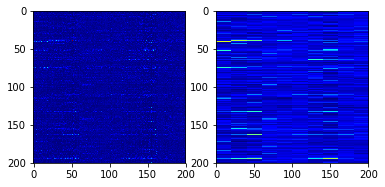

In [15]:
hist = createBlueHist(train)
plt.subplot(121)
plt.imshow(hist, cmap = 'jet')
normalHist = normalizeHist(hist)
plt.subplot(122)
plt.imshow(normalHist, cmap = 'jet')
plt.show()
